In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [ ]:
## on Google Colab
#! pip install lmp

# Exercise: Tensile strength test of Al

Molecular dynamics (MD) simulations allow us to observe how materials respond to mechanical loading at the atomic scale
In this exercise, you will study the elastic and plastic behavior of single-crystal aluminum under uniaxial tension using MD.
You will simulate an ideal, defect-free single crystal and extract the stress-strain response during deformation.

Specifically, you will:

- Perform a tensile loading simulation on single-crystal aluminum using an embedded-atom method (EAM) potential,

- Extract and plot the uniaxial stress-strain curve from the output data,

- Determine the elastic modulus of aluminum from the simulation,

- Discuss the limitations of MD-based mechanical testing.

1. Execute the following cell to create a LAMMPS input.

> Set `variable seed equal` to your matriculation number.

The provided LAMMPS input script simulates uniaxial tension of a perfect FCC aluminum crystal:

- A $10 \times 10 \times 10$ FCC unit cell block of aluminum is created using a lattice parameter of 4.05 Å and periodic boundaries in all directions.

- Potential: An EAM potential for aluminum (`Al99.eam.alloy`) models atomic interactions.

- The system is equilibrated at 300 K using a Nose-Hoover thermostat and barostat (`fix npt`).

- The crystal is stretched along the $x$-direction at a high strain rate of $10^{10} \, \text{s}^{-1}$ using `fix deform`, while maintaining constant pressure in the $y$ and $z$ directions.

- During deformation, the script computes:
  
  - the strain from the change in box length,
  
  - and the stress from the virial stress tensor (`pxx`, `pyy`, `pzz`), converted to GPa. These values are printed to a file (`Al_tensile.txt`) every 1000 timesteps.

- Atomic configuration dumps: Atomic snapshots are saved in `.cfg` format for visualization in tools like OVITO.

2. Execute the cell below the input script to run the simulation. It might take a bit — perfect time to grab a coffee.

In [ ]:
%%writefile in.tensile.txt
######################################
# LAMMPS INPUT SCRIPT
# Input file for uniaxial tensile loading of single crystal aluminum
# Mark Tschopp
# To execute, use the syntax "lmp_exe < in.tensile.txt" from command prompt

######################################
# VARIABLES
variable seed equal YOUR-MATRICULATION-NUMBER-HERE           # Your matriculation number 
variable n_iter equal 20000

######################################
# INITIALIZATION
units metal
dimension 3
boundary p p p
atom_style atomic
variable latparam equal 4.05

######################################
# ATOM DEFINITION
lattice  fcc ${latparam} orient x 1 0 0 orient y 0 1 0 orient z 0 0 1
region whole block 0 10 0 10 0 10
create_box 1 whole
create_atoms 1 region whole

######################################
# DEFINE INTERATOMIC POTENTIAL
pair_style eam/alloy
pair_coeff * * Al99.eam.alloy Al

######################################
# DEFINE COMPUTES 
compute csym all centro/atom fcc
compute peratom all pe/atom 

######################################
# EQUILIBRATION
reset_timestep 0
timestep 0.001
velocity all create 300 ${seed} mom yes rot no
fix 1 all npt temp 300 300 1 iso 0 0 1 drag 1 

# Set thermo output
thermo 1000
thermo_style custom step lx ly lz press pxx pyy pzz pe temp

# Run for at least 10 picosecond (assuming 1 fs timestep)
run 10000
unfix 1

# Store final cell length for strain calculations
variable tmp equal "lx"
variable L0 equal ${tmp}
print "Initial Length, L0: ${L0}"

######################################
# DEFORMATION
reset_timestep 0

fix 1 all npt temp 300 300 1 y 0 0 1 z 0 0 1 drag 1
variable srate equal 1.0e10
variable srate1 equal "v_srate / 1.0e12"
fix 2 all deform 1 x erate ${srate1} units box remap x

# Output strain and stress info to file
# for units metal, pressure is in [bars] = 100 [kPa] = 1/10000 [GPa]
# p2, p3, p4 are in GPa
variable strain equal "(lx - v_L0)/v_L0"
variable p1 equal "v_strain"
variable p2 equal "-pxx/10000"
variable p3 equal "-pyy/10000"
variable p4 equal "-pzz/10000"
fix def1 all print 100 "${p1} ${p2} ${p3} ${p4}" file Al_tensile.txt screen no

# Use cfg for AtomEye
dump 1 all cfg 250 dump.tens_*.cfg mass type xs ys zs c_csym c_peratom fx fy fz
dump_modify 1 element Al

# Display thermo
thermo 1000
thermo_style custom step v_strain temp v_p2 v_p3 v_p4 ke pe press
run 20000

######################################
# SIMULATION DONE
print "All done"

Overwriting in.tensile.txt


In [ ]:
## on Google Colab
#! lmp < in.tensile.txt
!mpirun -np 8 lmp_mpi < in.tensile.txt

LAMMPS (29 Aug 2024 - Update 2)
Lattice spacing in x,y,z = 4.05 4.05 4.05
Created orthogonal box = (0 0 0) to (40.5 40.5 40.5)
  2 by 2 by 2 MPI processor grid
Created 4000 atoms
  using lattice units in orthogonal box = (0 0 0) to (40.5 40.5 40.5)
  create_atoms CPU = 0.007 seconds
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 8.28721
  ghost atom cutoff = 8.28721
  binsize = 4.143605, bins = 10 10 10
  2 neighbor lists, perpetual/occasional/extra = 1 1 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
  (2) compute centro/atom, occasional
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory all

You can open `Al_tensile.txt` within Jupyter and see that it’s not in the most user-friendly format.

Let’s turn it into a tidy DataFrame by running the next cell:

In [ ]:
# Define column names
columns = ['strain', 'stress_xx (GPa)', 'stress_yy (GPa)', 'stress_zz (GPa)']

# Load data while skipping the comment line
df = pd.read_csv('Al_tensile.txt', 
                 sep='\s+', 
                 comment='#', 
                 names=columns)

df.round(3)

,strain,stress_xx (GPa),stress_yy (GPa),stress_zz (GPa)
0,0.000,0.011,0.009,0.018
1,0.001,0.075,0.001,-0.020
2,0.002,0.138,0.011,-0.007
3,0.003,0.178,0.014,0.007
4,0.004,0.262,-0.002,-0.010
...,...,...,...,...
196,0.196,1.418,-0.140,-0.096
197,0.197,1.491,0.074,0.079
198,0.198,1.316,-0.036,-0.007
199,0.199,1.362,-0.015,0.028


## Post-Processing the Simulation 
### Stress-Strain Plot

Although you're only actively deforming the system along the $x$-direction, stress may also develop in the $y$ and $z$ directions due to Poisson effects and thermal fluctuations. Plotting all three components — $\sigma_{xx}$, $\sigma_{yy}$, and $\sigma_{zz}$ — gives you a complete picture of the system’s response.

In the following snippet, you’ll use Seaborn to plot stress versus strain. Your task is to fill in the missing pieces (`'...'`) so that each stress component is plotted against strain on the same graph.

> The names of the quantities to be plotted (inside quotation marks) should match exactly the headers of the df we created in the previous cell, including capitalization, spacing, and units. 

Use the `label` command to differentiate each curve in the legend.

In [ ]:
sns.lineplot(data=df, x='...', y='...', label=r'$\sigma_{xx}$')
...
...


plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma$ (GPa)')


plt.grid(alpha=0.5)
plt.legend()
plt.show()

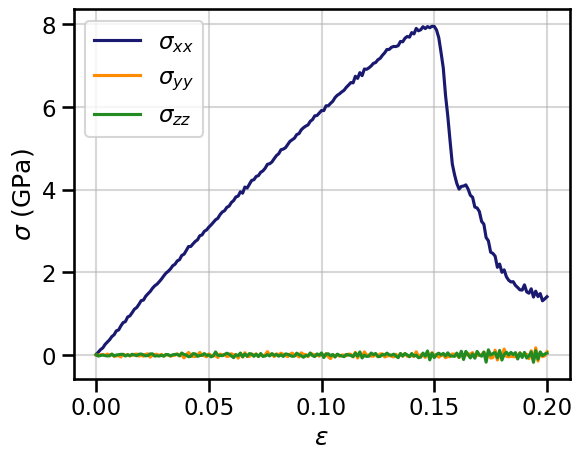

In [41]:
sns.lineplot(data=df, x='strain', y='stress_xx (GPa)', label=r'$\sigma_{xx}$', color='midnightblue')
sns.lineplot(data=df, x='strain', y='stress_yy (GPa)', label=r'$\sigma_{yy}$', color='darkorange')
sns.lineplot(data=df, x='strain', y='stress_zz (GPa)', label=r'$\sigma_{zz}$', color='forestgreen')

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma$ (GPa)')


plt.grid(alpha=0.5)
plt.legend()
plt.show()

To estimate the elastic modulus of aluminum, we take advantage of the fact that, in the elastic regime, stress and strain are linearly related by Hooke’s law:

$$
\sigma = E \cdot \epsilon
$$

In this snippet, you’ll extract the stress and strain values from the DataFrame and perform a simple linear fit to the first few points — which correspond to the earliest (and most linear) part of the stress-strain curve.

Specifically, this code selects the first `N` data points (here, `N = 10`) from the curve, fits a straight line through those points using `np.polyfit`, interprets the slope of that line as the elastic modulus $E$, measured in GPa.

- What happens if you increase N? Try changing it to 50, 100, or more: does E stay constant?

- Why is the elastic modulus most accurate at low strain?

- How does your computed E compare with experimental values for aluminum?

In [42]:
# Use stress_xx for uniaxial tension
strain = df['strain'].values
stress = df['stress_xx (GPa)'].values

# Use first N points (e.g., N = 10) for linear elastic fit
N = 10
slope, intercept = np.polyfit(strain[:N], stress[:N], 1)
E = slope  # Slope of the linear region

print(f"Elastic Modulus E ≈ {E:.2f} GPa")

Elastic Modulus E ≈ 62.92 GPa


***
## Making the Deformation Movie 

### Visualization in Windows with OVITO

First, download [OVITO](https://www.ovito.org/).

1. Go to [OVITO](https://www.ovito.org/).
2. Click on Download, select your operating system, and create a username to download the installer.
3. Follow the installation instructions to get it running on your computer.

#### Visualization Steps

1. Open OVITO.
2. Load the file `dump.tens_0.cfg`. OVITO will automatically detect and load the rest of the `*.cfg` files in the same directory.
3. From the **Add modification...** menu, select **Color coding**.
4. In the **Particle property** dropdown at the bottom, choose `c_csym`.
5. Click **Adjust range** to set a start and end value that enhances the visibility of dislocations.
6. Press the **Play** button to animate the deformation process.

#### Creating a Movie

1. Click the **Render Active Viewport** tab at the top.
2. In the **Rendering range** section, choose **Complete animation**.
3. Click **Save to file**, then hit **Choose...** and give your file a name such as `deformation-movie.png`.
4. (Optional) Check the box for **Transparent background**.
5. Finally, click **Render Active Viewport** to generate the animation frames.

To convert the frames into a movie or animated GIF, you can use tools like **ImageJ**, **FFmpeg**, or any video editor of your choice.

#### Additional Notes

- You can use **Add Modification... → Expression selection** to isolate atoms with low centrosymmetry values and then delete them from the view to better visualize defect structures.
- However, the current simulation cell may be too small to clearly observe dislocation nucleation and growth. To improve visibility, consider increasing the system size.

For example, in the LAMMPS input file, modify the region definition like so:

```lammps
# Original size (approx. 4,000 atoms)
region whole block 0 10 0 10 0 10

# Double the size (approx. 32,000 atoms)
region whole block 0 20 0 20 0 20

# Large system (approx. 500,000 atoms)
region whole block 0 50 0 50 0 50
```

> **Warning**: Simulating larger systems will significantly increase computation time. For anything beyond 32,000 atoms, you'll likely need access to multiple processors or a high-performance computing cluster. Running on a typical laptop may be impractical.


<br>
<table width="1000" border="0" cellpadding="5">
<tr>

<td width="300" align="center" valign="center">
<figure>
  <img src="https://cavs.msstate.edu/icme/code/lammps/tutorials/lammps/img/350px-Al_SC_100_disl.jpg" width="250" alt="Face-centered Cubic Lattice Structure" title="FCC Lattice Structure">
    <figcaption> Image of nucleated dislocation near peak stress.</figcaption>
</figure>
</td>

<td width="300" align="center" valign="center">
<figure>
  <img src="https://cavs.msstate.edu/icme/code/lammps/tutorials/lammps/img/Al_SC_100_movie1.gif" width="250" alt="Face-centered Cubic Lattice Structure" title="FCC Lattice Structure" />
  <figcaption> Tensile Loading of an Aluminum Single Crystal. Only atoms in non-centrosymmetric environment are shown.
  </figcaption>
</figure>
</td>

<td width="300" align="center" valign="center">
<figure>
  <img src="https://cavs.msstate.edu/icme/code/lammps/tutorials/lammps/img/Al_SC_100_movie2.gif" width="250" alt="Face-centered Cubic Lattice Structure" title="FCC Lattice Structure" />
  <figcaption> Tensile Loading of an Aluminum Single Crystal.
  </figcaption>
</figure>
</td>
</tr>
</table>
 